In [26]:
import h5py
import numpy as np

In [27]:
def func(name, obj):
    print(name)

In [28]:
file_name = 'step1_plane1.cgns'
with h5py.File(file_name) as f:
    print(f['Base']['Zone'].visititems(func))
    solution = f['Base']['Zone']['FlowSolution.N:1']['VelocityMagnitude'][' data'][:]
    coord_x = f['Base']['Zone']['GridCoordinates']['CoordinateX'][' data'][:]
    coord_y = f['Base']['Zone']['GridCoordinates']['CoordinateY'][' data'][:]
    coord_z = f['Base']['Zone']['GridCoordinates']['CoordinateZ'][' data'][:]
    connectivity = f['Base']['Zone']['plane-1-Pg']['ElementConnectivity'][' data'][:]

 data
FlowSolution.N:1
FlowSolution.N:1/VelocityMagnitude
FlowSolution.N:1/VelocityMagnitude/ data
GridCoordinates
GridCoordinates/CoordinateX
GridCoordinates/CoordinateX/ data
GridCoordinates/CoordinateY
GridCoordinates/CoordinateY/ data
GridCoordinates/CoordinateZ
GridCoordinates/CoordinateZ/ data
ZoneIterativeData
ZoneIterativeData/FlowSolutionPointers
ZoneIterativeData/FlowSolutionPointers/ data
ZoneType
ZoneType/ data
plane-1-Pg
plane-1-Pg/ data
plane-1-Pg/ElementConnectivity
plane-1-Pg/ElementConnectivity/ data
plane-1-Pg/ElementRange
plane-1-Pg/ElementRange/ data
plane-1-Pg/ElementStartOffset
plane-1-Pg/ElementStartOffset/ data
None


In [29]:
print(len(solution))
print(len(coord_x))
print(len(connectivity))

print(min(coord_x))
print(max(coord_x))
print(min(coord_y))
print(max(coord_y))
print(min(coord_z))
print(max(coord_z))

# remove y axis

168462
168462
532679
-0.2127000007838009
0.439268006064534
0.22663051540857052
0.22663249444599012
-0.4317500123903155
0.20635000486224886


In [ ]:
def Intersection(x1, y1, x2, y2, x3, y3, x4, y4):
    """
    Calculate if two lines intersect
    """
    # line1
    k1 = (y2 - y1) / (x2 - x1)
    b1 = y1 - k1 * x1
    # line2
    k2 = (y4 - y3) / (x4 - x3)
    b2 = y3 - k2 * x3
    # if the two lines are parallel
    if k1 == k2:
        return False
    else:
        # the intersection point
        x = (b2 - b1) / (k1 - k2)
        y = k1 * x + b1
        # if the intersection point is on the two lines
        if (x1 <= x <= x2 or x2 <= x <= x1) and (x3 <= x <= x4 or x4 <= x <= x3):
            return True
        else:
            return False


def Intersection2D(line, rectangle):
    '''
    Calculate if the line intersects the rectangle
    :param line: [[x1, y1], [x2, y2]]
    :param rectangle: [[x1, y1], [x2, y2], [x3, y3], [x4, y4]]
    '''
    # line
    x1 = line[0][0]
    y1 = line[0][1]
    x2 = line[1][0]
    y2 = line[1][1]
    # rectangle
    x3 = rectangle[0][0]
    y3 = rectangle[0][1]
    x4 = rectangle[1][0]
    y4 = rectangle[1][1]
    x5 = rectangle[2][0]
    y5 = rectangle[2][1]
    x6 = rectangle[3][0]
    y6 = rectangle[3][1]
    # if the line intersects with any of the four edges of the rectangle, return True
    if Intersection(x1, y1, x2, y2, x3, y3, x4, y4) or Intersection(x1, y1, x2, y2, x4, y4, x5, y5) or Intersection(x1,
                                                                                                                  y1,
                                                                                                                  x2,
                                                                                                                  y2,
                                                                                                                  x5,
                                                                                                                  y5,
                                                                                                                  x6,
                                                                                                                  y6) or Intersection(
            x1, y1, x2, y2, x6, y6, x3, y3):
        return True
    else:
        return False



False


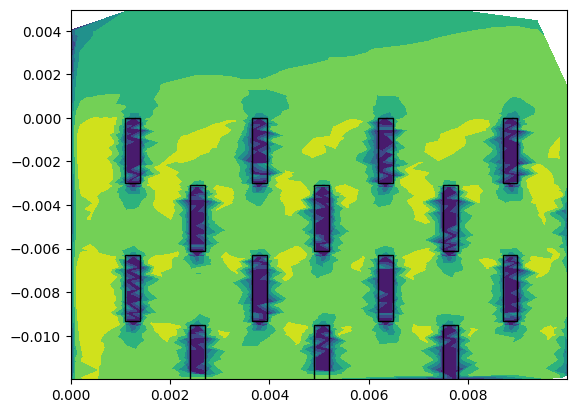

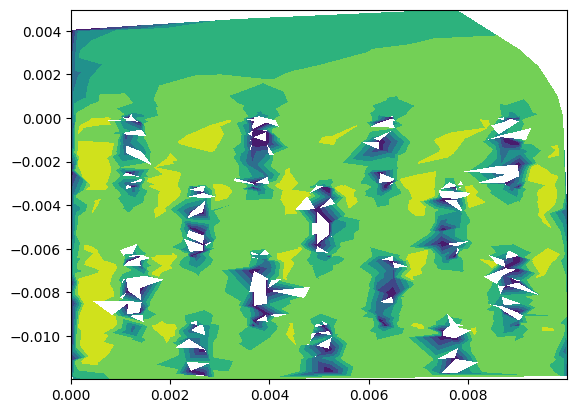

In [30]:
# construct connectivity matrix based on connectivity
connectivity_list = []
for i in range(len(connectivity)-1):
    connectivity_list.append(np.array([connectivity[i], connectivity[i+1]]))
    connectivity_list.append(np.array([connectivity[i+1], connectivity[i]]))

connectivity_list = np.array(connectivity_list)

import torch
import torch_geometric as pyg
from torch_geometric.data import Data
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation

# construct edge_index
edge_index = torch.tensor(connectivity_list, dtype=torch.long).t().contiguous()

data = Data(x=torch.tensor(solution, dtype=torch.float), edge_index=edge_index)
print(data.is_directed())

# select points within the region of x = [-0.01, 0.4], z = [-0.01, 0.4]
solution_reduced = solution[(coord_x > -0.005) & (coord_x < 0.01) & (coord_z > -0.012) & (coord_z < 0.005)]
coord_x_reduced = coord_x[(coord_x > -0.005) & (coord_x < 0.01) & (coord_z > -0.012) & (coord_z < 0.005)]
coord_z_reduced = coord_z[(coord_x > -0.005) & (coord_x < 0.01) & (coord_z > -0.012) & (coord_z < 0.005)]
# pick connectivity containing the index of nodes in the reduced mesh
# for i in range(len(connectivity_list)):
#     if (coord_x[connectivity_list[i][0]] > -0.005) & (coord_x[connectivity_list[i][0]] < 0.02) & (coord_z[connectivity_list[i][0]] > -0.02) & (coord_z[connectivity_list[i][0]] < 0.005) & (coord_x[connectivity_list[i][1]] > -0.005) & (coord_x[connectivity_list[i][1]] < 0.02) & (coord_z[connectivity_list[i][1]] > -0.02) & (coord_z[connectivity_list[i][1]] < 0.005):
#         connectivity_list[i] = np.array([np.where(coord_x_reduced == coord_x[connectivity_list[i][0]])[0][0], np.where(coord_x_reduced == coord_x[connectivity_list[i][1]])[0][0]])
#     else:
#         connectivity_list[i] = np.array([-1, -1])
# data_reduced = Data(x=torch.tensor(solution_reduced, dtype=torch.float), edge_index=edge_index)

tri = Triangulation(coord_x_reduced, coord_z_reduced)
plt.tricontourf(tri, solution_reduced)
# plot a governing rectangle
square0 = plt.Rectangle((0.00365, -0.003), width=0.0003, height=0.003, fill=False)
square1 = plt.Rectangle((0.0011, -0.003), width=0.0003, height=0.003, fill=False)
square2 = plt.Rectangle((0.0062, -0.003), width=0.0003, height=0.003, fill=False)
square3 = plt.Rectangle((0.0087, -0.003), width=0.0003, height=0.003, fill=False)
square4 = plt.Rectangle((0.0024, -0.0061), width=0.0003, height=0.003, fill=False)
square5 = plt.Rectangle((0.0049, -0.0061), width=0.0003, height=0.003, fill=False)
square6 = plt.Rectangle((0.0075, -0.0061), width=0.0003, height=0.003, fill=False)
square7 = plt.Rectangle((0.00365, -0.0093), width=0.0003, height=0.003, fill=False)
square8 = plt.Rectangle((0.0062, -0.0093), width=0.0003, height=0.003, fill=False)
square9 = plt.Rectangle((0.0011, -0.0093), width=0.0003, height=0.003, fill=False)
square10 = plt.Rectangle((0.0087, -0.0093), width=0.0003, height=0.003, fill=False)
square11 = plt.Rectangle((0.0024, -0.0125), width=0.0003, height=0.003, fill=False)
square12 = plt.Rectangle((0.0049, -0.0125), width=0.0003, height=0.003, fill=False)
square13 = plt.Rectangle((0.0075, -0.0125), width=0.0003, height=0.003, fill=False)

plt.gca().add_patch(square0)
plt.gca().add_patch(square1)
plt.gca().add_patch(square2)
plt.gca().add_patch(square3)
plt.gca().add_patch(square4)
plt.gca().add_patch(square5)
plt.gca().add_patch(square6)
plt.gca().add_patch(square7)
plt.gca().add_patch(square8)
plt.gca().add_patch(square9)
plt.gca().add_patch(square10)
plt.gca().add_patch(square11)
plt.gca().add_patch(square12)
plt.gca().add_patch(square13)
plt.show()

# sample 2 every 5 points to form a coarser mesh 
solution_reduced = solution_reduced[::3]
coord_x_reduced = coord_x_reduced[::3]
coord_z_reduced = coord_z_reduced[::3]
tri = Triangulation(coord_x_reduced, coord_z_reduced)
# plt.tricontourf(tri, solution_reduced)

# remove all the edges inside the rectangles from tri
triangles = tri.triangles
# use Intersection2D to determine if the edge is inside the rectangle, and remove it if it is
triangles_new = []
for i in range(len(triangles)):
    if Intersection2D([[coord_x_reduced[triangles[i][0]], coord_z_reduced[triangles[i][0]]], [coord_x_reduced[triangles[i][1]], coord_z_reduced[triangles[i][1]]]], [[0.00365, -0.003], [0.0011, -0.003], [0.0062, -0.003], [0.0087, -0.003]]) == False and Intersection2D([[coord_x_reduced[triangles[i][0]], coord_z_reduced[triangles[i][0]]], [coord_x_reduced[triangles[i][1]], coord_z_reduced[triangles[i][1]]]], [[0.0024, -0.0061], [0.0049, -0.0061], [0.0075, -0.0061], [0.00365, -0.0093]]) == False and Intersection2D([[coord_x_reduced[triangles[i][0]], coord_z_reduced[triangles[i][0]]], [coord_x_reduced[triangles[i][1]], coord_z_reduced[triangles[i][1]]]], [[0.0062, -0.0093], [0.0011, -0.0093], [0.0087, -0.0093], [0.0024, -0.0125]]) == False and Intersection2D([[coord_x_reduced[triangles[i][0]], coord_z_reduced[triangles[i][0]]], [coord_x_reduced[triangles[i][1]], coord_z_reduced[triangles[i][1]]]], [[0.0049, -0.0125], [0.0075, -0.0125], [0.00365, -0.003], [0.0011, -0.003]]) == False:
        triangles_new.append(triangles[i])

